In [105]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, BatchNormalization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras

preprocessing the data, renaming columns name and casting

In [106]:
def get_data():
    df = pd.read_csv("eth.csv")
    df.columns = ["date", "close", "open", "high", "low", "volume", "pct"]
    df.date = df.date.str.replace("年", "/")
    df.date = df.date.str.replace("月", "/")
    df.date = df.date.str.replace("日", "")
    df.date = pd.to_datetime(df.date)
    for col in df.columns[1:]:
        df[col] = df[col].str.replace(",", "")
        df[col] = df[col].str.replace("%", "")
        df[col] = df[col].str.replace("K", "")
        df[col] = df[col].str.replace("M", "")
        df[col] = df[col].str.replace("-", "")
        df[col] = pd.to_numeric(df[col], errors = "raise")
    return df

split and slice data with ratio and length

In [107]:
def get_train_test_data(eth, ratio = 0.3, length = 5, cols = ["close"]):
    '''
    ratio: 0 < ratio < 1
    length: length >= 1
    cols: [close|open|high|low|volume|pct]
    '''
    tmp = eth.copy(deep=True)
    recover = {"close":{}, "open": {}, "high": {}, "low": {}}
    recover["close"]["std"] = eth.close.std()
    recover["close"]["mean"] = eth.close.mean()
    recover["open"]["std"] = eth.open.std()
    recover["open"]["mean"] = eth.open.mean()   
    recover["high"]["std"] = eth.high.std()
    recover["high"]["mean"] = eth.high.mean()   
    recover["low"]["std"] = eth.low.std()
    recover["low"]["mean"] = eth.low.mean()   
    tmp.close = (eth.close - recover["close"]["mean"]) / recover["close"]["std"]
    tmp.open = (eth.open - recover["open"]["mean"]) / recover["open"]["std"]
    tmp.high = (eth.high - recover["high"]["mean"]) / recover["high"]["std"]
    tmp.low = (eth.low - recover["low"]["mean"]) / recover["low"]["std"]
    y = tmp.close[: -length]
    x = np.stack([tmp.loc[index + 1: index + length, cols] for index in y.index])
    x = np.reshape(x, (x.shape[0], len(cols), x.shape[1]))
    index = list(tmp.index).index(int(len(tmp.index) * ratio))=
    x_train, x_test, y_train, y_test = x[index:], x[:index], y[index:], y[:index]
    return x_train, x_test, y_train, y_test, recover


SyntaxError: invalid syntax (696730454.py, line 24)

In [108]:
def get_model(train_x):
    model = Sequential()
    print(train_x.shape)
    model.add(LSTM(units = 50, input_shape = (train_x.shape[1], train_x.shape[2])))
    model.add(BatchNormalization(momentum=0.98))
    model.add(Dropout(0.3))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.summary()
    return model

In [109]:
def recover_value(y, recover, col):
    return y * recover[col]["std"] + recover[col]["mean"]

In [110]:
eth = get_data()
train_x, test_x, train_y, test_y, recover = get_train_test_data(eth)
model = get_model(train_x)
history = model.fit(
    train_x, train_y,
    epochs=100, batch_size=16, validation_split=0.1)

(1489, 1, 5)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50)                11200     
                                                                 
 batch_normalization_21 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,451
Trainable params: 11,351
Non-trainable params: 100
_________________________________________________________________
Epoch 1/100
84/84 [==============================] - 2s 8ms/step - loss: 0.1209 - val_loss: 0.0483
E

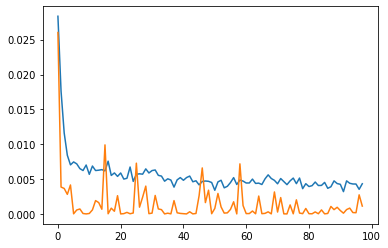

In [111]:
# first and second's loss is too big, let's ignore them
plt.plot(history.history["loss"][2:])
plt.plot(history.history["val_loss"][2:])
# history.history.keys()

the result seem the model is convergence, but loss decrease slowly after 80 epoch, so add early stopping

In [112]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
eth = get_data()
train_x, test_x, train_y, test_y, recover = get_train_test_data(eth)
model = get_model(train_x)
history = model.fit(
    train_x, train_y,
    epochs=100, batch_size=16,
    validation_split=0.1, callbacks=callback)

(1489, 1, 5)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 50)                11200     
                                                                 
 batch_normalization_22 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,451
Trainable params: 11,351
Non-trainable params: 100
_________________________________________________________________
Epoch 1/100
84/84 [==============================] - 2s 8ms/step - loss: 0.0846 - val_loss: 0.0435
E

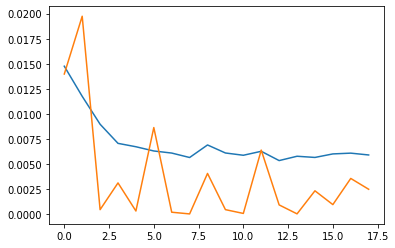

In [113]:
plt.plot(history.history["loss"][2:])
plt.plot(history.history["val_loss"][2:])
# history.history.keys()

In [114]:
predicted = model.predict(test_x)
# print(predicted)
# print(predicted[:5], train_y.values[:5])
predicted = np.reshape(predicted, (predicted.size,))
org_test_y = recover_value(test_y, recover, "close")
predicted = recover_value(predicted, recover, "close")
predicted = np.reshape(predicted, (predicted.size,))

In [115]:
print(len(test_x))

639


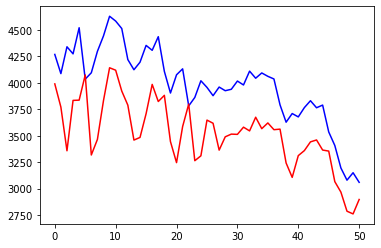

In [116]:
plt.plot(org_test_y.values[50::-1], color="b")
plt.plot(predicted[50::-1], color="r")
plt.show()

the image show that result of predict is slowly then the reality, let's visualize more

In [117]:
ma = org_test_y.rolling(window=2).mean()
ma

0           NaN
1      3104.955
2      3115.160
3      3137.665
4      3301.540
         ...   
634     171.470
635     162.605
636     155.675
637     157.415
638     157.555
Name: close, Length: 639, dtype: float64

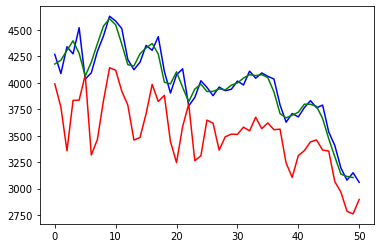

In [118]:
plt.plot(org_test_y.values[50::-1], color="b")
plt.plot(predicted[50::-1], color="r")
plt.plot(ma.values[50::-1], color="g")
plt.show()

In [119]:
def acc_with_raise_or_decrease(x, y):
    count = 0
    for i in range(len(x) - 1):
        count += 1 if (x[i] - x[i+1]) * (y[i] - y[i+1]) > 0 else 0
    return count / (len(x) - 1)

lstm_result = acc_with_raise_or_decrease(org_test_y.values[::-1], predicted[::-1])
ma_result = acc_with_raise_or_decrease(ma.values[::-1], predicted[::-1])

print(lstm_result, ma_result)

0.4608150470219436 0.4843260188087774


In trending predict moving average performance is better then using lstm model, trying using more feature in model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
eth = get_data()
train_x, test_x, train_y, test_y, recover = get_train_test_data(eth, length=10, cols = ["close", "open"])
model = get_model(train_x)
history = model.fit(
    train_x, train_y,
    epochs=100, batch_size=16,
    validation_split=0.1, callbacks=callback)

In [120]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
eth = get_data()
# try add more feature
train_x, test_x, train_y, test_y, recover = get_train_test_data(eth, length=10, cols = ["close","open"])
model = get_model(train_x)
history = model.fit(
    train_x, train_y,
    epochs=100, batch_size=16,
    validation_split=0.1, callbacks=callback)


(1484, 2, 10)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                12200     
                                                                 
 batch_normalization_23 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12,451
Trainable params: 12,351
Non-trainable params: 100
_________________________________________________________________
Epoch 1/100
84/84 [==============================] - 2s 9ms/step - loss: 0.3355 - val_loss: 0.0314


In [121]:
ma = org_test_y.rolling(window=2).mean()
ma

0           NaN
1      3104.955
2      3115.160
3      3137.665
4      3301.540
         ...   
634     171.470
635     162.605
636     155.675
637     157.415
638     157.555
Name: close, Length: 639, dtype: float64

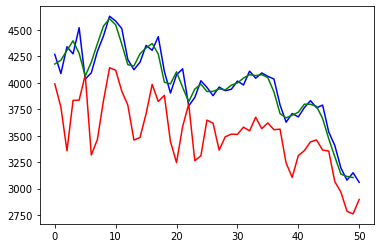

In [122]:
plt.plot(org_test_y.values[50::-1], color="b")
plt.plot(predicted[50::-1], color="r")
plt.plot(ma.values[50::-1], color="g")
plt.show()

In [123]:
lstm_result = acc_with_raise_or_decrease(org_test_y.values[::-1], predicted[::-1])
ma_result = acc_with_raise_or_decrease(ma.values[::-1], predicted[::-1])

print(lstm_result, ma_result)

0.4608150470219436 0.4843260188087774


performance didn't improve. Result show that we can't only use LSTM model to predict trending of market.